# 04 - Exploratory Data Analysis (EDA)

Understand the "shape" of risk through visualization and analysis.

**Key Questions**:

1. Do higher interest rates correlate with higher default rates?
2. What is the income distribution of defaulters vs. non-defaulters?
3. How do other features relate to default risk?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import warnings

warnings.filterwarnings("ignore")

# Plot settings
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 11

# Paths
INTERIM_DATA = Path("../data/interim/lending_club_cleaned.parquet")
FIGURES_DIR = Path("../reports/figures")
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

In [2]:
# Load cleaned data (before encoding for interpretable analysis)
df = pd.read_parquet(INTERIM_DATA)
print(f"Loaded data shape: {df.shape}")
print(f"Default rate: {df['default'].mean():.2%}")

Loaded data shape: (1345310, 70)
Default rate: 19.96%


## 1. Target Variable Distribution


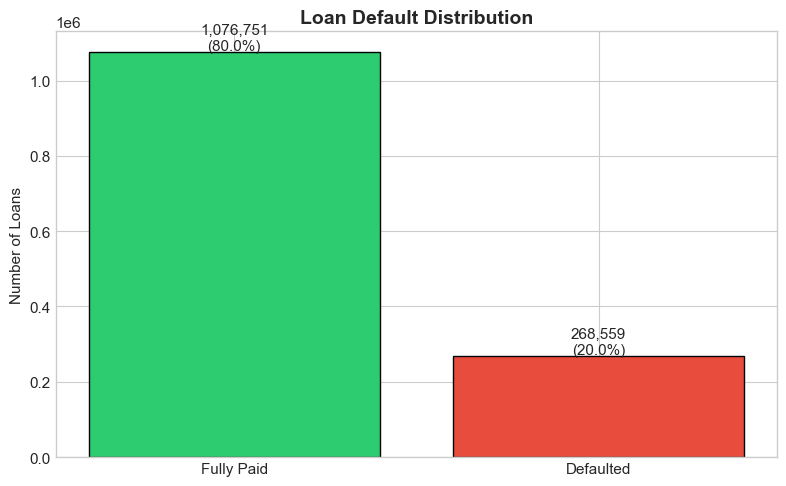


Class imbalance ratio: 1:4.0 (non-default:default)


In [3]:
fig, ax = plt.subplots(figsize=(8, 5))

colors = ["#2ecc71", "#e74c3c"]  # Green for paid, Red for default
counts = df["default"].value_counts().sort_index()
bars = ax.bar(
    ["Fully Paid", "Defaulted"], counts.values, color=colors, edgecolor="black"
)

ax.set_title("Loan Default Distribution", fontsize=14, fontweight="bold")
ax.set_ylabel("Number of Loans")

# Add count labels
for bar, count in zip(bars, counts.values):
    pct = count / len(df) * 100
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 5000,
        f"{count:,}\n({pct:.1f}%)",
        ha="center",
        fontsize=11,
    )

plt.tight_layout()
plt.savefig(FIGURES_DIR / "target_distribution.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"\nClass imbalance ratio: 1:{counts[0] / counts[1]:.1f} (non-default:default)")

## 2. Interest Rate vs Default

**Hypothesis**: Higher interest rates indicate higher perceived risk, leading to higher default rates.


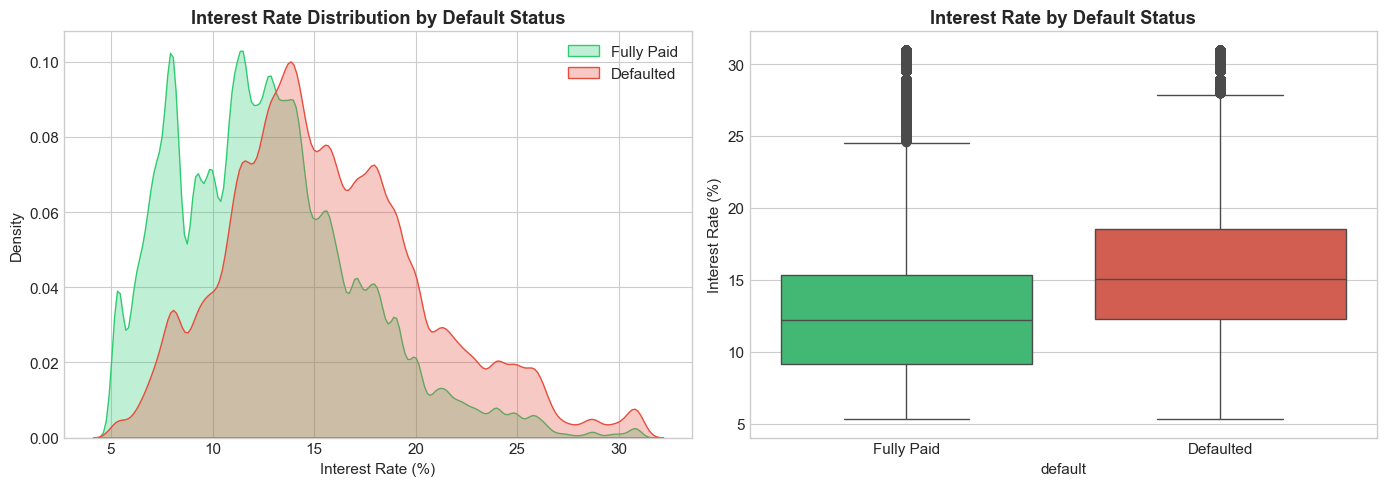

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution by default status
for default_val, label, color in [
    (0, "Fully Paid", "#2ecc71"),
    (1, "Defaulted", "#e74c3c"),
]:
    subset = df[df["default"] == default_val]["int_rate"]
    sns.kdeplot(data=subset, ax=axes[0], label=label, color=color, fill=True, alpha=0.3)

axes[0].set_title("Interest Rate Distribution by Default Status", fontweight="bold")
axes[0].set_xlabel("Interest Rate (%)")
axes[0].legend()

# Box plot comparison
sns.boxplot(
    data=df, x="default", y="int_rate", ax=axes[1], palette=["#2ecc71", "#e74c3c"]
)
axes[1].set_xticklabels(["Fully Paid", "Defaulted"])
axes[1].set_title("Interest Rate by Default Status", fontweight="bold")
axes[1].set_ylabel("Interest Rate (%)")

plt.tight_layout()
plt.savefig(FIGURES_DIR / "interest_rate_analysis.png", dpi=150, bbox_inches="tight")
plt.show()

In [5]:
# Statistical test: T-test
defaulted_rates = df[df["default"] == 1]["int_rate"]
paid_rates = df[df["default"] == 0]["int_rate"]

t_stat, p_value = stats.ttest_ind(defaulted_rates, paid_rates)

print("Interest Rate Analysis")
print("=" * 50)
print(
    f"Defaulted loans - Mean: {defaulted_rates.mean():.2f}%, Median: {defaulted_rates.median():.2f}%"
)
print(
    f"Paid loans      - Mean: {paid_rates.mean():.2f}%, Median: {paid_rates.median():.2f}%"
)
print(f"\nT-test: t = {t_stat:.2f}, p-value = {p_value:.2e}")
print(
    f"\nConclusion: {'Significant difference!' if p_value < 0.05 else 'No significant difference'}"
)

Interest Rate Analysis
Defaulted loans - Mean: 15.71%, Median: 15.05%
Paid loans      - Mean: 12.62%, Median: 12.23%

T-test: t = 310.75, p-value = 0.00e+00

Conclusion: Significant difference!


## 3. Income Distribution Analysis


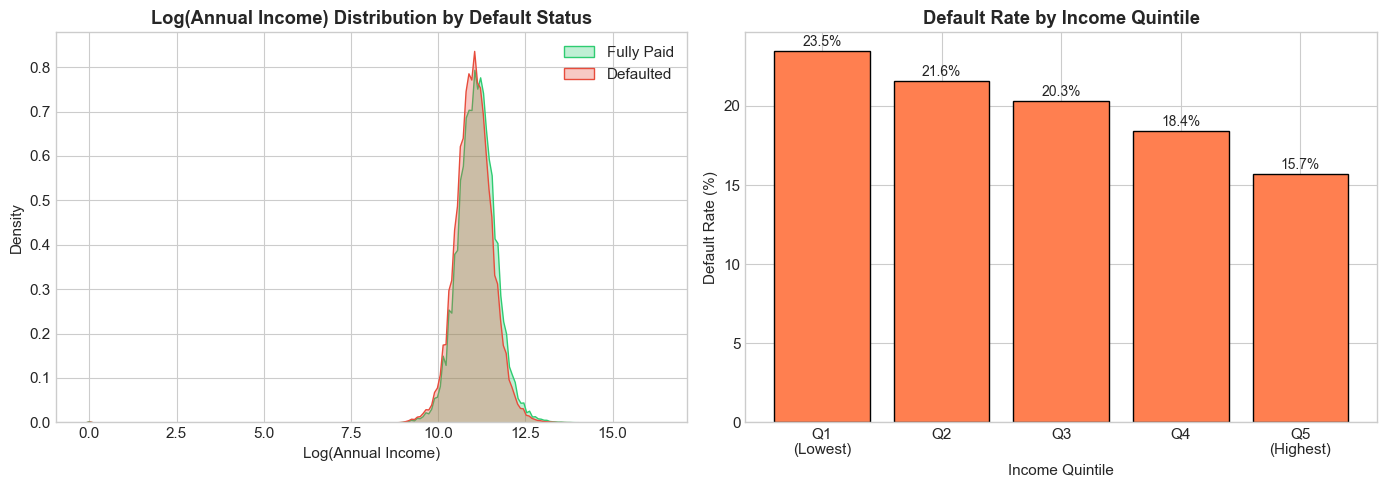

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Log-transformed income distribution
df["log_income"] = np.log1p(df["annual_inc"])

for default_val, label, color in [
    (0, "Fully Paid", "#2ecc71"),
    (1, "Defaulted", "#e74c3c"),
]:
    subset = df[df["default"] == default_val]["log_income"]
    sns.kdeplot(data=subset, ax=axes[0], label=label, color=color, fill=True, alpha=0.3)

axes[0].set_title(
    "Log(Annual Income) Distribution by Default Status", fontweight="bold"
)
axes[0].set_xlabel("Log(Annual Income)")
axes[0].legend()

# Default rate by income quintile
df["income_quintile"] = pd.qcut(
    df["annual_inc"], 5, labels=["Q1\n(Lowest)", "Q2", "Q3", "Q4", "Q5\n(Highest)"]
)
default_by_income = df.groupby("income_quintile")["default"].mean() * 100

bars = axes[1].bar(
    default_by_income.index, default_by_income.values, color="coral", edgecolor="black"
)
axes[1].set_title("Default Rate by Income Quintile", fontweight="bold")
axes[1].set_ylabel("Default Rate (%)")
axes[1].set_xlabel("Income Quintile")

# Add value labels
for bar, val in zip(bars, default_by_income.values):
    axes[1].text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.3,
        f"{val:.1f}%",
        ha="center",
        fontsize=10,
    )

plt.tight_layout()
plt.savefig(FIGURES_DIR / "income_analysis.png", dpi=150, bbox_inches="tight")
plt.show()

## 4. Default Rate by Loan Grade


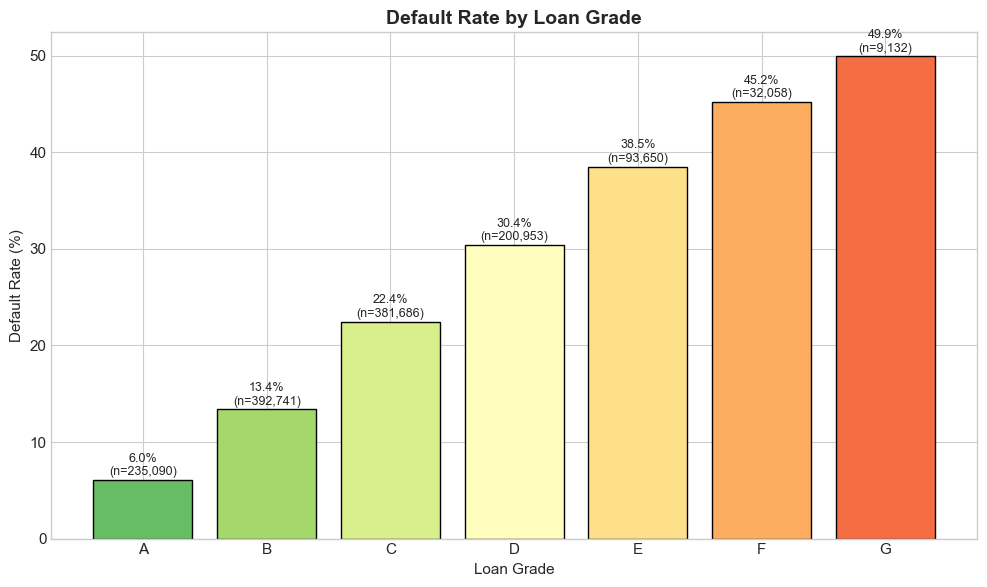


Grade Statistics:
grade  default_rate  count  avg_int_rate
    A      0.060407 235090      7.113039
    B      0.133852 392741     10.679129
    C      0.224396 381686     14.021234
    D      0.303822 200953     17.721618
    E      0.384784  93650     21.138086
    F      0.452024  32058     24.934785
    G      0.499343   9132     27.725938


In [7]:
fig, ax = plt.subplots(figsize=(10, 6))

# Group by grade
grade_stats = (
    df.groupby("grade")
    .agg(
        default_rate=("default", "mean"),
        count=("default", "count"),
        avg_int_rate=("int_rate", "mean"),
    )
    .reset_index()
)

# Sort by grade
grade_order = ["A", "B", "C", "D", "E", "F", "G"]
grade_stats["grade"] = pd.Categorical(
    grade_stats["grade"], categories=grade_order, ordered=True
)
grade_stats = grade_stats.sort_values("grade")

# Create gradient colors from green (A) to red (G)
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(grade_stats)))

bars = ax.bar(
    grade_stats["grade"],
    grade_stats["default_rate"] * 100,
    color=colors,
    edgecolor="black",
)

ax.set_title("Default Rate by Loan Grade", fontsize=14, fontweight="bold")
ax.set_xlabel("Loan Grade")
ax.set_ylabel("Default Rate (%)")

# Add count labels
for bar, (_, row) in zip(bars, grade_stats.iterrows()):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.5,
        f"{row['default_rate'] * 100:.1f}%\n(n={row['count']:,})",
        ha="center",
        fontsize=9,
    )

plt.tight_layout()
plt.savefig(FIGURES_DIR / "default_by_grade.png", dpi=150, bbox_inches="tight")
plt.show()

print("\nGrade Statistics:")
print(grade_stats.to_string(index=False))

## 5. Correlation Heatmap


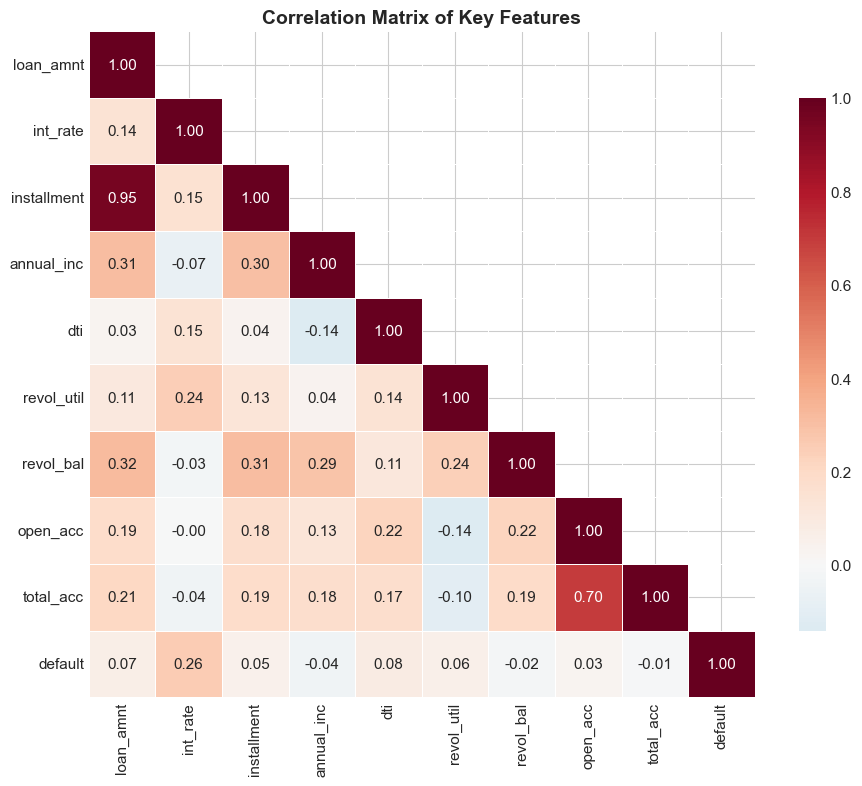

In [8]:
# Select key numeric features
numeric_cols = [
    "loan_amnt",
    "int_rate",
    "installment",
    "annual_inc",
    "dti",
    "revol_util",
    "revol_bal",
    "open_acc",
    "total_acc",
    "default",
]
numeric_cols = [c for c in numeric_cols if c in df.columns]

corr_matrix = df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="RdBu_r",
    center=0,
    fmt=".2f",
    ax=ax,
    square=True,
    mask=mask,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
)

ax.set_title("Correlation Matrix of Key Features", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "correlation_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()

In [9]:
# Features most correlated with default
correlations_with_default = (
    df[numeric_cols].corrwith(df["default"]).abs().sort_values(ascending=False)
)

print("Features Most Correlated with Default:")
print("=" * 40)
for feat, corr in correlations_with_default.items():
    if feat != "default":
        print(f"{feat:20} {corr:.4f}")

Features Most Correlated with Default:
int_rate             0.2588
dti                  0.0845
loan_amnt            0.0656
revol_util           0.0600
installment          0.0517
annual_inc           0.0418
open_acc             0.0281
revol_bal            0.0200
total_acc            0.0113


## 6. Home Ownership & Loan Purpose


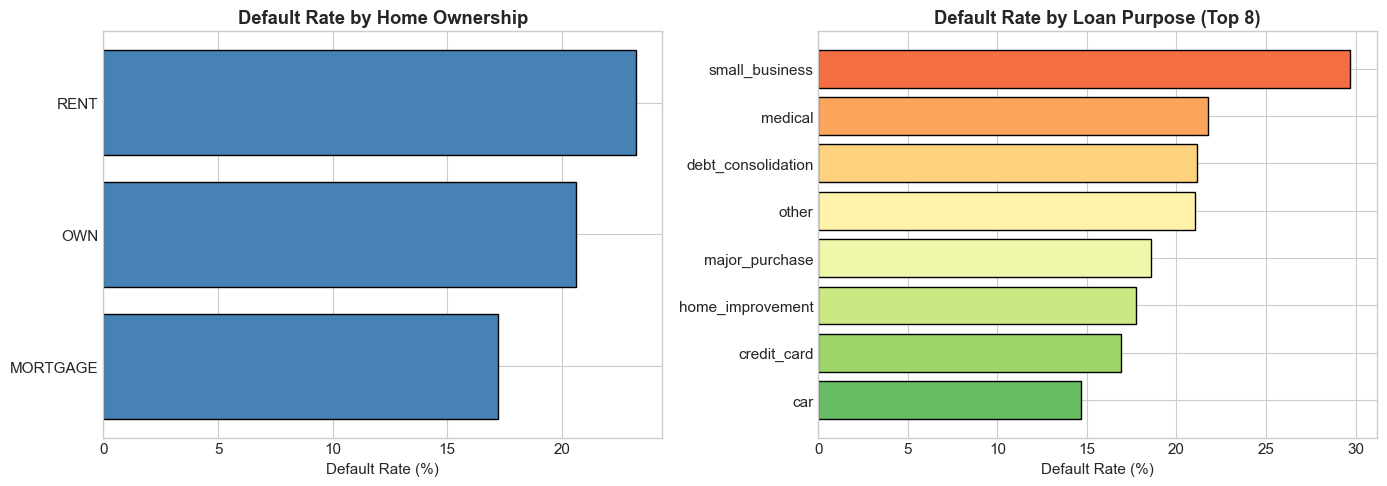

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Home ownership
home_stats = (
    df.groupby("home_ownership")["default"].agg(["mean", "count"]).reset_index()
)
home_stats = home_stats[home_stats["count"] > 1000].sort_values("mean")
axes[0].barh(
    home_stats["home_ownership"],
    home_stats["mean"] * 100,
    color="steelblue",
    edgecolor="black",
)
axes[0].set_title("Default Rate by Home Ownership", fontweight="bold")
axes[0].set_xlabel("Default Rate (%)")

# Loan purpose (top 8)
purpose_stats = df.groupby("purpose")["default"].agg(["mean", "count"]).reset_index()
purpose_stats = purpose_stats.nlargest(8, "count").sort_values("mean")
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(purpose_stats)))
axes[1].barh(
    purpose_stats["purpose"],
    purpose_stats["mean"] * 100,
    color=colors,
    edgecolor="black",
)
axes[1].set_title("Default Rate by Loan Purpose (Top 8)", fontweight="bold")
axes[1].set_xlabel("Default Rate (%)")

plt.tight_layout()
plt.savefig(FIGURES_DIR / "default_by_category.png", dpi=150, bbox_inches="tight")
plt.show()

## 7. Key Findings Summary


In [11]:
print("=" * 60)
print("EDA KEY FINDINGS")
print("=" * 60)
print(f"""
1. CLASS IMBALANCE
   - Default rate: {df["default"].mean():.1%}
   - Requires class_weight='balanced' in modeling

2. INTEREST RATE vs DEFAULT
   - Defaulted loans have significantly higher interest rates
   - Strong predictor (p < 0.001)

3. INCOME vs DEFAULT
   - Lower income correlates with higher default risk
   - Clear gradient across quintiles

4. LOAN GRADE
   - Strongest predictor: A = lowest risk, G = highest risk
   - Grades capture the bank's risk assessment well

5. TOP FEATURES FOR MODELING
   - int_rate, grade, dti, revol_util, annual_inc
""")

EDA KEY FINDINGS

1. CLASS IMBALANCE
   - Default rate: 20.0%
   - Requires class_weight='balanced' in modeling

2. INTEREST RATE vs DEFAULT
   - Defaulted loans have significantly higher interest rates
   - Strong predictor (p < 0.001)

3. INCOME vs DEFAULT
   - Lower income correlates with higher default risk
   - Clear gradient across quintiles

4. LOAN GRADE
   - Strongest predictor: A = lowest risk, G = highest risk
   - Grades capture the bank's risk assessment well

5. TOP FEATURES FOR MODELING
   - int_rate, grade, dti, revol_util, annual_inc



## Next Steps

Proceed to `05_modeling.ipynb` to train and evaluate models.
